# Multi-Class Prediction of Obesity Risk


## Informações sobre o notebook


### Entrega
Link do para o Colab: 

Usuário no Kaggle: renanrms

Link para o Notebook no Github: https://github.com/renanrms/datamining-t1/blob/main/src/solution.ipynb

Link para o Github: https://github.com/renanrms/datamining-t1


### Processo de desenvolvimento

Os passos que segui para desenvolver a solução neste notebook foram:
1. Carregar os dados e construir uma análise exploratória básica, em que a maioria das colunas categóricas era analisada.
2. Construir um pré-processamento dos dados suficiente para que o modelo pudesse rodar e avalia-lo por treino e teste.
3. Implementar cross-validation
4. Trabalhar na visualização detalhada de um modelo, com matriz de confusão, visualização do desempenho em treino e teste para avaliar se está ocorrendo overfitting, etc.
5. Construí a seção de comparação de modelos, que avalia entre os modelos e pré-processamentos desejados, apresentando tabelas parcial e acumulada com o desempenho de cada modelo testado.
6. Desenvolvi a parte de otimização dos hiperparâmetros do modelo, usando GridSearchCV.
7. Fiz mais alguns detalhes na análise exploratória, para ter mais possibilidades no pré-processamento, em especial.
8. Realizei alguns ciclos de comparação dos modelos, selecionando as melhores opções de pré-processamento e de modelos, comentando as demais para reduzir o escopo das buscas.
9. Fiz otimizações no modelo que teve o melhor desempenho, o RandomForest, adicionando cada variante mais otimizada na lista de modelos de comparação
10. Voltei a fazer mais comparações de desempenho com cada versão dos modelos e com algumas possibilidades de pré-processamento.


## Preparação do ambiente e dos dados


### Imports e Configurações Gerais


In [81]:
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from datetime import datetime
from itertools import product
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import (
    cross_val_predict,
    cross_validate,
    train_test_split
)
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    f1_score,
    make_scorer,
    precision_score,
    recall_score,
)

from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier

%matplotlib inline

# seaborn.set_theme()

### Funções


#### show_stats ( )


In [82]:
def show_stats(dataframe):
    """
    Retorna dataframe contendo a contagem de valores inválidos (None, NaN, NaT) em cada coluna do dataframe passado como parâmetro.
    """

    data_dict = {
        c: [
            dataframe.columns[c],
            (dataframe.shape[0] - dataframe[dataframe.columns[c]].count()),
            len(dataframe[dataframe.columns[c]].unique()),
            dataframe[dataframe.columns[c]].dtype,
        ]
        for c in range(len(dataframe.columns))
    }

    return pd.DataFrame(
        data=data_dict, index=["Nome", "Val. inválidos", "Val. únicos", "Tipo"]
    ).T

### Carregamento dos Dados


In [83]:
train = pd.read_csv("../data/train.csv")
test = pd.read_csv("../data/test.csv")

## Análise Exploratória


### Visão Geral


Os dados estão todos completos, sem valores faltantes ou evidentemente inválidos (ex: NaN) em nenhuma coluna.

Há [Informações sobre o significado de cada coluna](https://www.kaggle.com/competitions/playground-series-s4e2/discussion/472516) em comentário no Kaggle.


In [84]:
train.head()

id  Gender        Age    Height      Weight family_history_with_overweight  \
0   0    Male  24.443011  1.699998   81.669950                            yes   
1   1  Female  18.000000  1.560000   57.000000                            yes   
2   2  Female  18.000000  1.711460   50.165754                            yes   
3   3  Female  20.952737  1.710730  131.274851                            yes   
4   4    Male  31.641081  1.914186   93.798055                            yes   

  FAVC      FCVC       NCP        CAEC SMOKE      CH2O SCC       FAF  \
0  yes  2.000000  2.983297   Sometimes    no  2.763573  no  0.000000   
1  yes  2.000000  3.000000  Frequently    no  2.000000  no  1.000000   
2  yes  1.880534  1.411685   Sometimes    no  1.910378  no  0.866045   
3  yes  3.000000  3.000000   Sometimes    no  1.674061  no  1.467863   
4  yes  2.679664  1.971472   Sometimes    no  1.979848  no  1.967973   

        TUE       CALC                 MTRANS           NObeyesdad  
0  0.976473  Sometimes  Public_Transportation  Overweight_Level_II  
1  1.000000         no             Automobile        Normal_Weight  
2  1.673584         no  Public_Transportation  Insufficient_Weight  
3  0.780199  Sometimes  Public_Transportation     Obesity_Type_III  
4  0.931721  Sometimes  Public_Transportation  Overweight_Level_II

In [85]:
show_stats(train)

Nome Val. inválidos Val. únicos     Tipo
0                               id              0       20758    int64
1                           Gender              0           2   object
2                              Age              0        1703  float64
3                           Height              0        1833  float64
4                           Weight              0        1979  float64
5   family_history_with_overweight              0           2   object
6                             FAVC              0           2   object
7                             FCVC              0         934  float64
8                              NCP              0         689  float64
9                             CAEC              0           4   object
10                           SMOKE              0           2   object
11                            CH2O              0        1506  float64
12                             SCC              0           2   object
13                             FAF              0        1360  float64
14                             TUE              0        1297  float64
15                            CALC              0           3   object
16                          MTRANS              0           5   object
17                      NObeyesdad              0           7   object

In [86]:
binary_columns = ["family_history_with_overweight", "FAVC", "SMOKE", "SCC"]
categorical_columns = ["Gender", "CAEC", "CALC", "MTRANS", "NObeyesdad"]
numerical_columns = ["Age", "Height", "Weight", "FCVC", "NCP", "CH2O", "FAF", "TUE"]

### Atributos categóricos


#### NObeyesdad (Target)


Para este atributo será feito ordinal encoding, porque há uma ordem clara entre as classes e este é o target, portanto está é a técnica mais usual para que a saída do algoritmo possa ser numérica.


In [87]:
print(train.NObeyesdad.unique())

['Overweight_Level_II' 'Normal_Weight' 'Insufficient_Weight'
 'Obesity_Type_III' 'Obesity_Type_II' 'Overweight_Level_I'
 'Obesity_Type_I']


In [88]:
target_order = [
    "Insufficient_Weight",
    "Normal_Weight",
    "Overweight_Level_I",
    "Overweight_Level_II",
    "Obesity_Type_I",
    "Obesity_Type_II",
    "Obesity_Type_III",
]

#### Gender


Pela característica do atributo (não ter uma ordem), certamente vamos utilizar o One Hot Encoding. Que neste caso será como um atributo binário porque por conta da opção drop="First" que será usada.


In [89]:
print(train.Gender.unique())
print(test.Gender.unique())

['Male' 'Female']
['Male' 'Female']


In [90]:
gender_options = ["Male", "Female"]

#### CAEC


In [91]:
print(train.CAEC.unique())
print(test.CAEC.unique())

['Sometimes' 'Frequently' 'no' 'Always']
['Sometimes' 'Always' 'Frequently' 'no']


In [92]:
CAEC_options = ["no", "Sometimes", "Frequently", "Always"]

#### CALC


Para este atributo há uma ordem muito clara entre as classes, de maneira que podemos fazer ordinal encoding, mas também podemos fazer one hot encoding, que possui a vantagem de não atribuir uma escala às classes. Mas ambos os métodos podem ser testados.


In [93]:
print(train.CALC.unique())
print(test.CALC.unique())

['Sometimes' 'no' 'Frequently']
['Sometimes' 'no' 'Frequently' 'Always']


In [94]:
CALC_options = ["no", "Sometimes", "Frequently", "Always"]

#### MTRANS


Neste atributo podemos proceder de duas maneiras principais:

- Utilizar One Hot Encoding. Escolha que considero mais certeira por não atribuir ordem ou escala.
- Definir uma ordem e utilizar ordinal encoding. Neste caso podemos olhar o comportamento do atributo em relação ao target para validar a ordem escolhida para cada classe.


In [95]:
print(train.MTRANS.unique())
print(test.MTRANS.unique())

['Public_Transportation' 'Automobile' 'Walking' 'Motorbike' 'Bike']
['Public_Transportation' 'Automobile' 'Walking' 'Bike' 'Motorbike']


A tabela a seguir correlaciona MTRANS às classes do target. Com isso podemos ter uma opção de definição da ordem deste atributo seguindo este resultado, podendo ter outras possibilidades para testar o desempanho dos modelos


In [96]:
target_encoder = OrdinalEncoder(categories=[target_order], dtype=int)

train_copy = train.copy()

train_copy["NObeyesdad_encoded"] = target_encoder.fit_transform(
    train_copy[["NObeyesdad"]]
).flatten()

train_copy[["MTRANS", "NObeyesdad_encoded"]].groupby("MTRANS").mean().sort_values(
    by=["NObeyesdad_encoded"], ascending=True
)

NObeyesdad_encoded
MTRANS                                   
Walking                          1.629550
Bike                             1.781250
Motorbike                        1.868421
Automobile                       3.201188
Public_Transportation            3.323306

As três opções para teste são declaradas no bloco a seguir:

- A primeira é arbitrária
- A segunda foi definida seguindo uma ordem que tenta ir do maior nível de atividade física para o menor
- A terceira segue a ordem obtida da tabela acima


In [97]:
MTRANS_options_1 = [
    "Walking",
    "Public_Transportation",
    "Bike",
    "Motorbike",
    "Automobile",
]

MTRANS_options_2 = [
    "Bike",
    "Walking",
    "Public_Transportation",
    "Motorbike",
    "Automobile",
]

MTRANS_options_3 = [
    "Walking",
    "Bike",
    "Motorbike",
    "Automobile",
    "Public_Transportation",
]

### Matriz de dispersão


In [98]:
preprocessor = ColumnTransformer(
    transformers=[
        (
            "Num1",
            "passthrough",
            numerical_columns,
        ),
        (
            "G1",
            OneHotEncoder(
                categories=[gender_options], drop="first", sparse_output=False
            ),
            ["Gender"],
        ),
        ("CAEC2", OrdinalEncoder(categories=[CAEC_options], dtype=int), ["CAEC"]),
        ("C2", OrdinalEncoder(categories=[CALC_options], dtype=int), ["CALC"]),
        ("M2", OrdinalEncoder(categories=[MTRANS_options_3], dtype=int), ["MTRANS"]),
        (
            "Bin1",
            OrdinalEncoder(
                # categories=[["no", "yes"]],
                handle_unknown="use_encoded_value",
                unknown_value=-1,
                dtype=int,
            ),
            binary_columns,
        ),
        (
            "Tar1",
            OrdinalEncoder(categories=[target_order], dtype=int),
            ["NObeyesdad"],
        ),
    ]
)

preprocessor.fit(train)
col_names = preprocessor.get_feature_names_out()
# print(col_names)

transformed_data = preprocessor.transform(train)
if hasattr(transformed_data, "toarray"):
    transformed_data = transformed_data.toarray()

processed_train = pd.DataFrame(
    data=transformed_data,  # Garante array denso # type: ignore
    columns=col_names,
    index=train.index,
)  # type: ignore

display(processed_train.head())

Num1__Age  Num1__Height  Num1__Weight  Num1__FCVC  Num1__NCP  Num1__CH2O  \
0  24.443011      1.699998     81.669950    2.000000   2.983297    2.763573   
1  18.000000      1.560000     57.000000    2.000000   3.000000    2.000000   
2  18.000000      1.711460     50.165754    1.880534   1.411685    1.910378   
3  20.952737      1.710730    131.274851    3.000000   3.000000    1.674061   
4  31.641081      1.914186     93.798055    2.679664   1.971472    1.979848   

   Num1__FAF  Num1__TUE  G1__Gender_Female  CAEC2__CAEC  C2__CALC  M2__MTRANS  \
0   0.000000   0.976473                0.0          1.0       1.0         4.0   
1   1.000000   1.000000                1.0          2.0       0.0         3.0   
2   0.866045   1.673584                1.0          1.0       0.0         4.0   
3   1.467863   0.780199                1.0          1.0       1.0         4.0   
4   1.967973   0.931721                0.0          1.0       1.0         4.0   

   Bin1__family_history_with_overweight  Bin1__FAVC  Bin1__SMOKE  Bin1__SCC  \
0                                   1.0         1.0          0.0        0.0   
1                                   1.0         1.0          0.0        0.0   
2                                   1.0         1.0          0.0        0.0   
3                                   1.0         1.0          0.0        0.0   
4                                   1.0         1.0          0.0        0.0   

   Tar1__NObeyesdad  
0               3.0  
1               1.0  
2               0.0  
3               6.0  
4               3.0

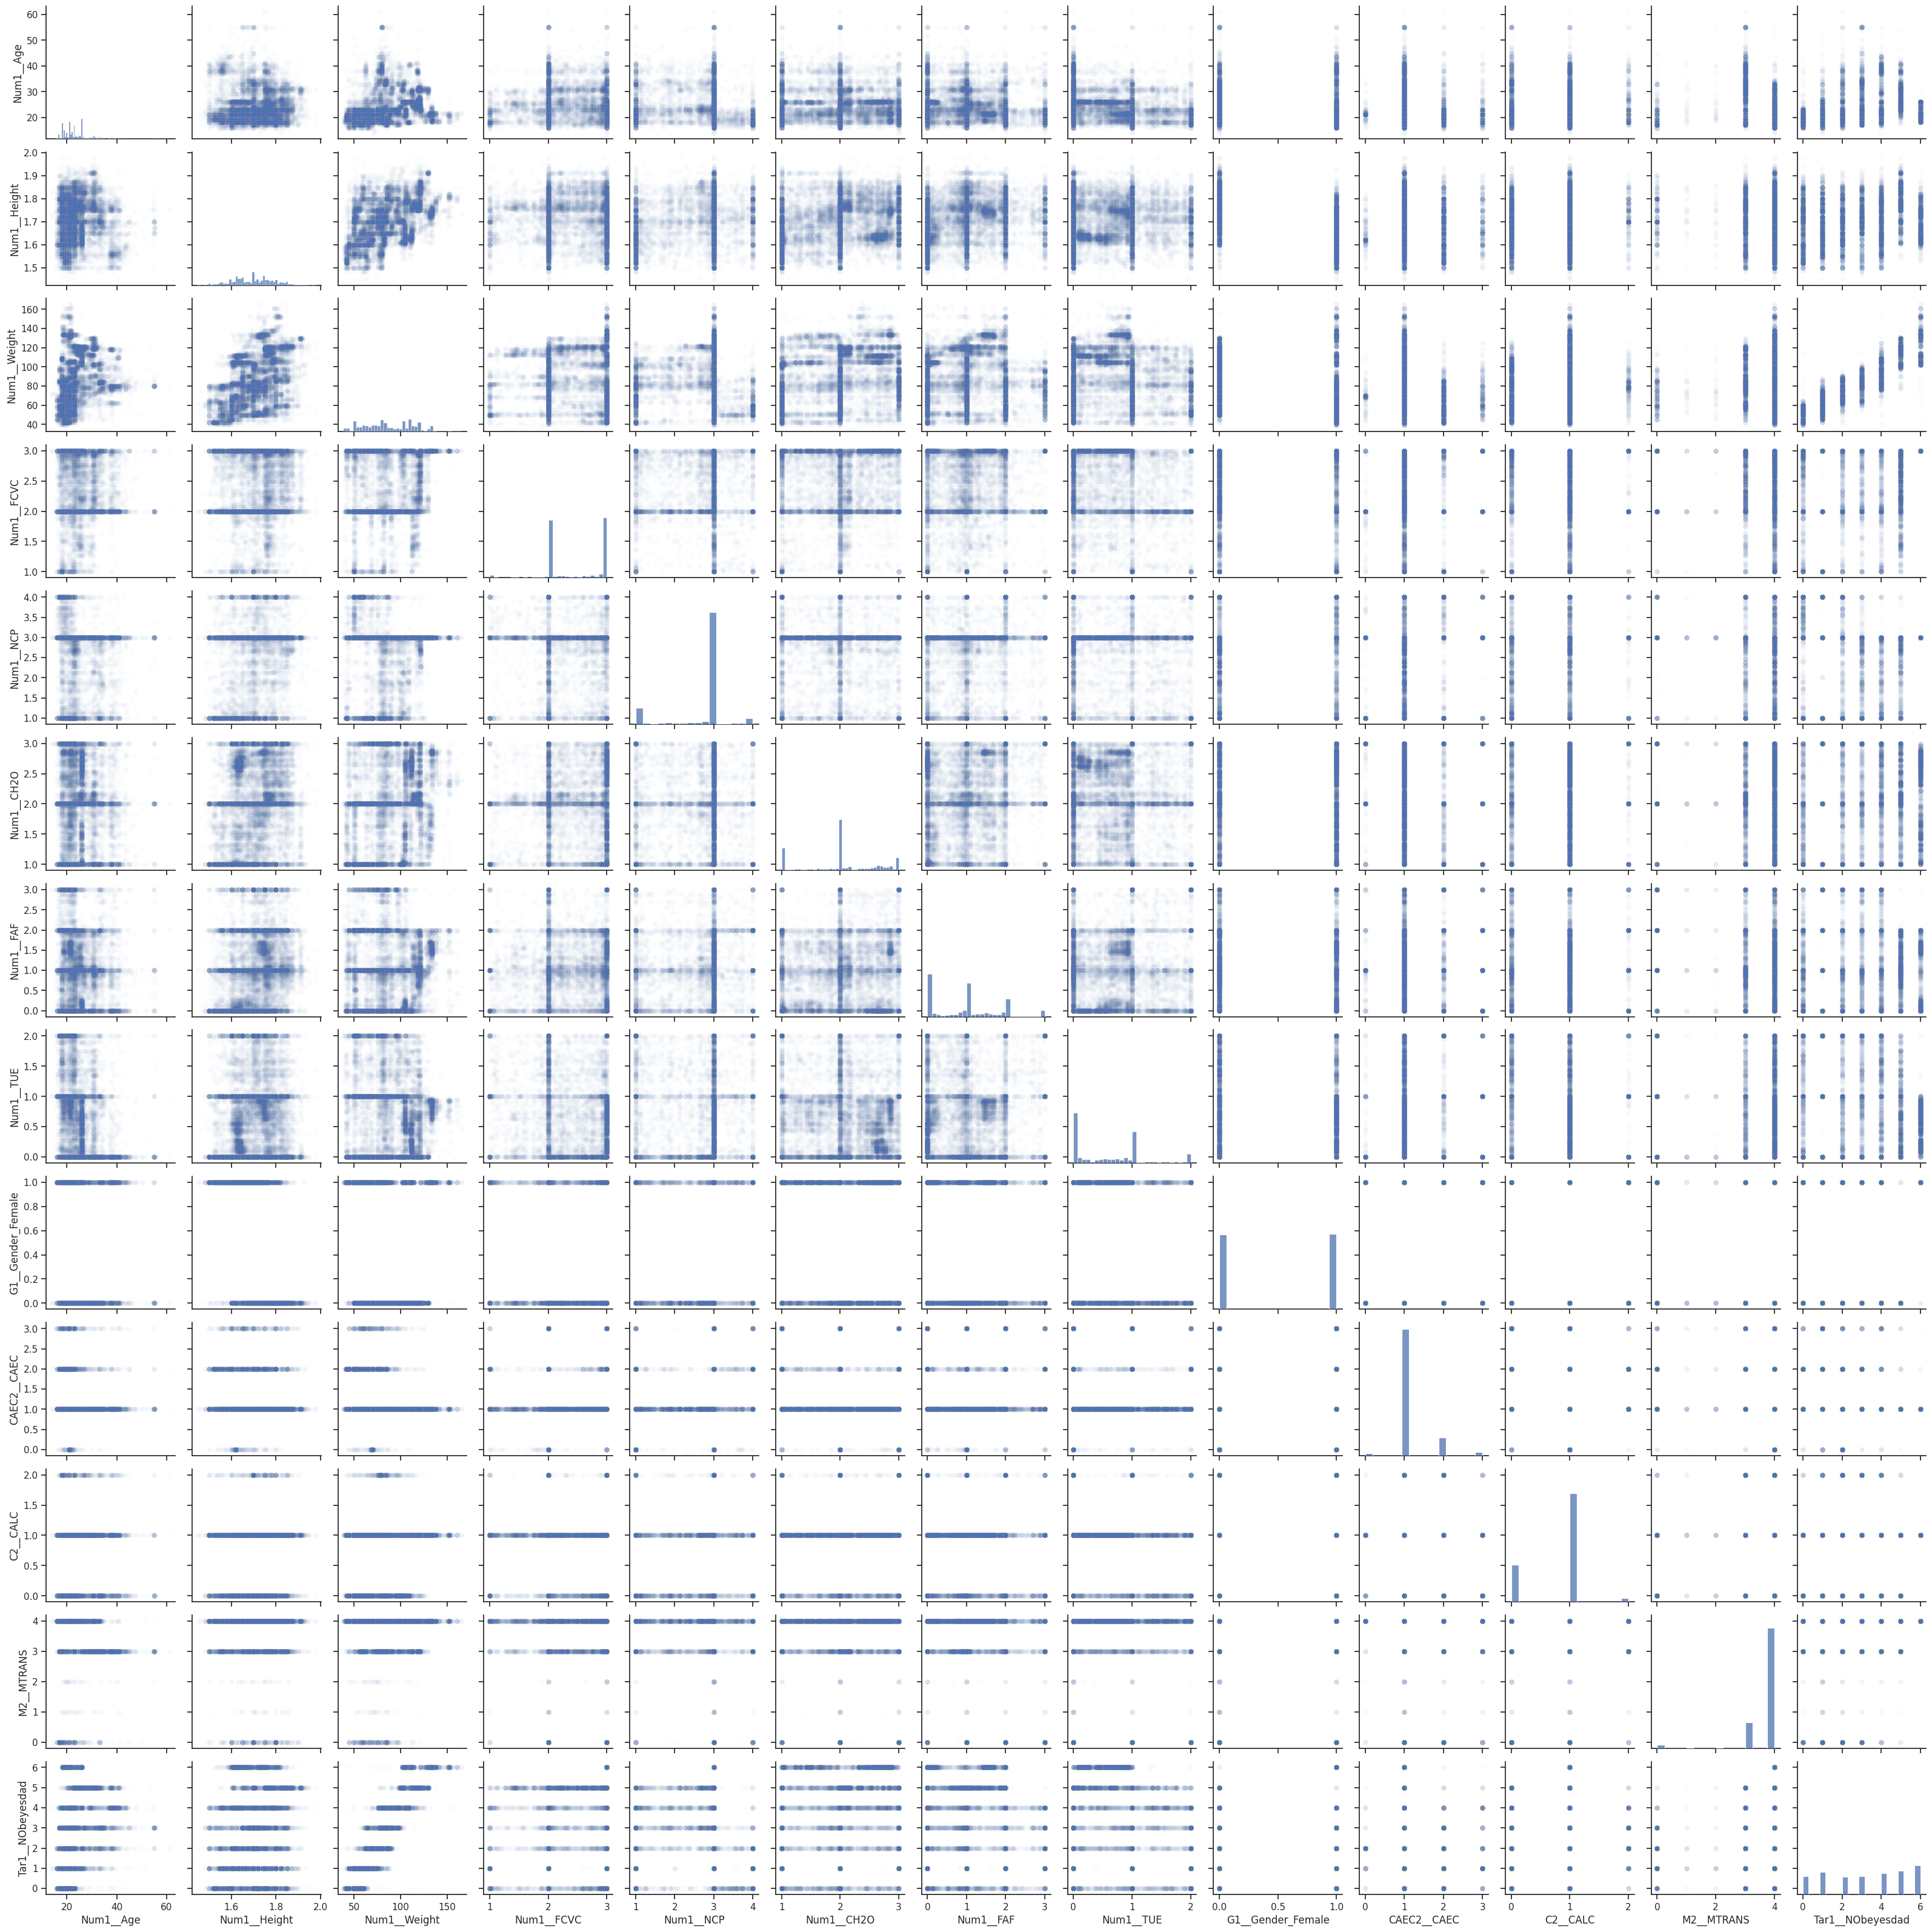

In [99]:
sns.set_theme(style="ticks")
# Remove colunas binárias para a figura não ficar grande demais
sns.pairplot(processed_train.drop(columns=col_names[12:16]), plot_kws={"alpha": 0.02})
# sns.pairplot(processed_train, plot_kws={"alpha": 0.01})

### Matriz de correlação


In [100]:
# Compute the correlation matrix
corr = processed_train.corr()

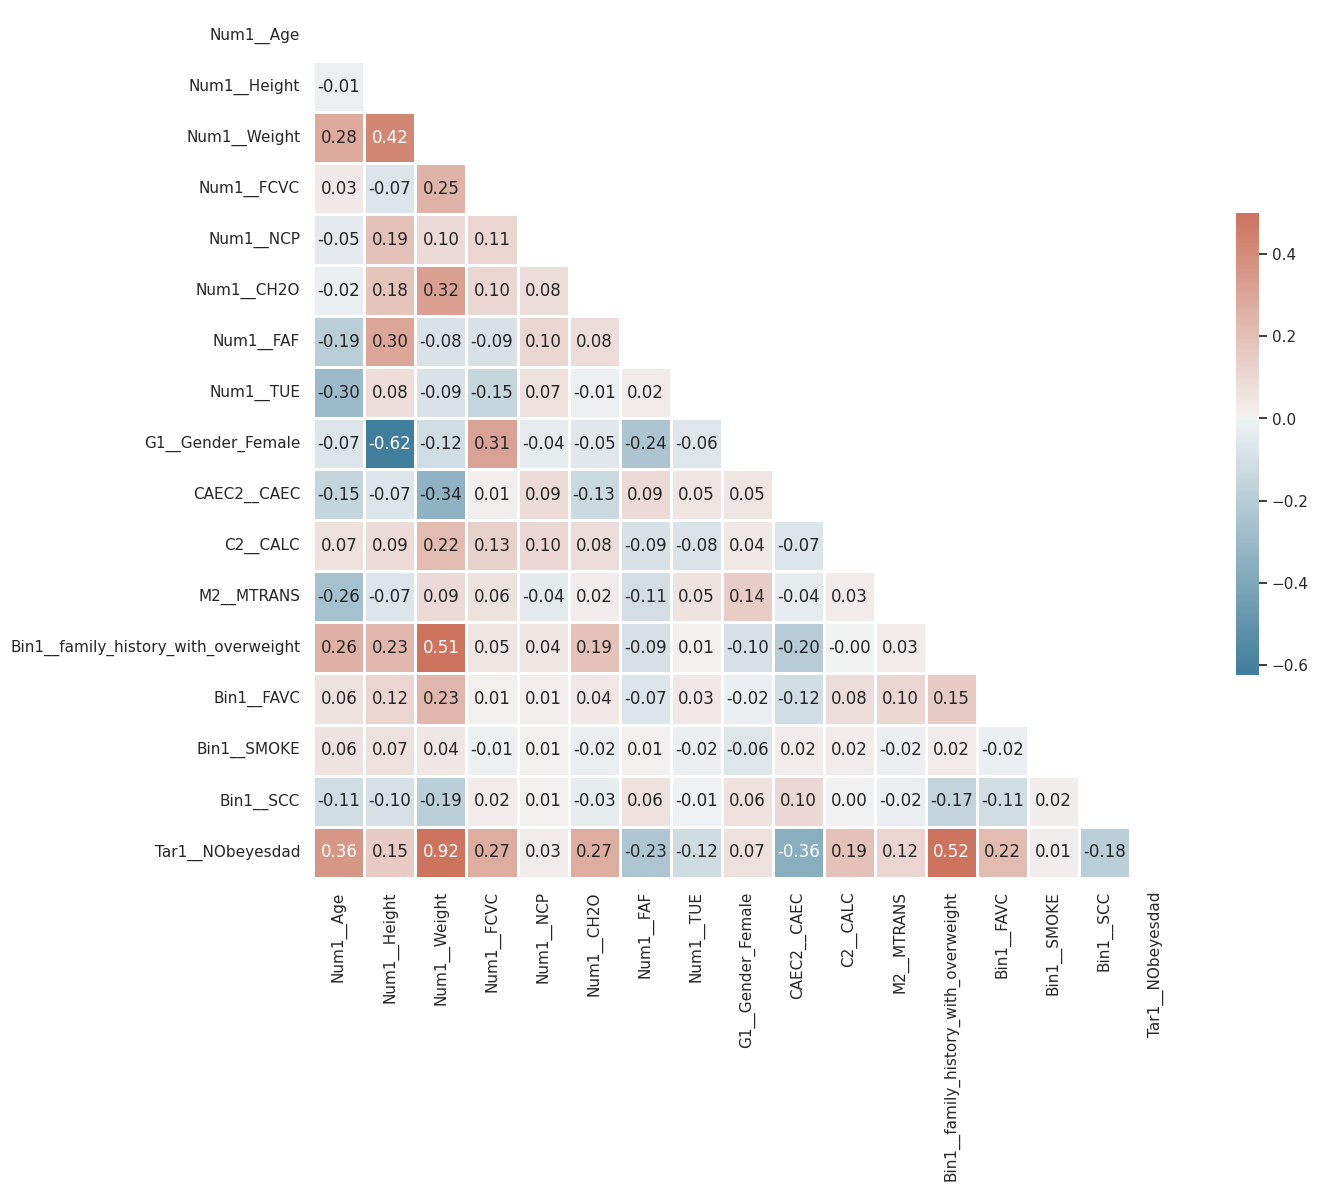

In [101]:
sns.set_theme(style="white")

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(14, 12))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
plot = sns.heatmap(
    corr,
    mask=mask,
    cmap=cmap,
    vmax=0.5,
    center=0,
    annot=True,
    square=True,
    linewidths=1,
    cbar_kws={"shrink": 0.5},
    fmt=".2f",
)

## Comparação de modelos


### Separação das Labels


Vamos separar o dataset de maneira a ficar com o mesmo formato que teriam os dados reais com o modelo em produção, ou seja, sem o target.

Teremos um dataset apenas com as features e uma série apenas com os targets, ambos com mesma altura.


In [102]:
target_encoder = OrdinalEncoder(categories=[target_order], dtype=int)

train["NObeyesdad_encoded"] = target_encoder.fit_transform(
    train[["NObeyesdad"]]
).flatten()

features = train.drop(["NObeyesdad", "NObeyesdad_encoded"], axis=1)
target = train["NObeyesdad_encoded"]

### Modelos


A seguir são definidos os modelos que poderão ser usados no problema.

Os modelos foram reordenados de maneira a facilitar o uso do modelo com melhor desempenho nas etapas seguintes. Assim, as melhores opções foram colocadas em primeiro na lista. Uma lista foi criada apenas com os melhores modelos.


In [ ]:
models = [
    (
        "RFR-3",
        RandomForestClassifier(n_estimators=175, max_depth=20, min_samples_split=8),
    ),
    (
        "RFR-2",
        RandomForestClassifier(n_estimators=100, max_depth=20, min_samples_split=10),
    ),
    (
        "RFR",
        RandomForestClassifier(),
    ),
    ("KNN", KNeighborsClassifier()),
    ("DTR", DecisionTreeClassifier()),
    ("SVC", SVC()),
    ("GNB", GaussianNB()),
]

best_models = models[0:3]

### Pré-processamentos


A seguir é definido um dicionário que contém, como valores, listas de transformers excludentes nos entre si.

Ou seja, deve ser aplicado apenas um transformer de cada listas, assim podemos testar opções como usar one hot encoding ou label encoding em uma determinada coluna.

Para algumas colunas (ou conjuntos de colunas) há apenas uma opção.

Algumas opções poderão ser comentadas conforme se verifica o seu desempenho, mas sempre mantendo o registro para saber qual tratamento foi usado para cada resultado.


In [ ]:
transformers = {
    "Numerical": [
        (
            "Num1",
            "passthrough",
            numerical_columns,
        )
    ],
    "Gender": [
        (
            "G1",
            OneHotEncoder(
                categories=[gender_options], drop="first", sparse_output=False
            ),
            ["Gender"],
        ),
    ],
    "CAEC": [
        ("CE2", OrdinalEncoder(categories=[CAEC_options], dtype=int), ["CAEC"]),
        # (
        #     "CE1",
        #     OneHotEncoder(categories=[CAEC_options], drop="first", sparse_output=False),
        #     ["CAEC"],
        # ),
    ],
    "CALC": [
        ("C2", OrdinalEncoder(categories=[CALC_options], dtype=int), ["CALC"]),
        (
            "C1",
            OneHotEncoder(categories=[CALC_options], drop="first", sparse_output=False),
            ["CALC"],
        ),
    ],
    "MTRANS": [
        ("M4", OrdinalEncoder(categories=[MTRANS_options_3], dtype=int), ["MTRANS"]),
        (
            "M1",
            OneHotEncoder(
                categories=[MTRANS_options_1], drop="first", sparse_output=False
            ),
            ["MTRANS"],
        ),
        ("M2", OrdinalEncoder(categories=[MTRANS_options_1], dtype=int), ["MTRANS"]),
        # ("M3", OrdinalEncoder(categories=[MTRANS_options_2], dtype=int), ["MTRANS"]),
    ],
}

# Melhor transformer de cada atributo/tipo
best_transformers = [
    transformers["Numerical"][0],
    transformers["Gender"][0],
    transformers["CAEC"][0],
    transformers["CALC"][0],
    transformers["MTRANS"][0],
]

### Resultados comparativos entre modelos/pré-processamentos


Define um variável acumuladora de resultados se não estiver definida.

OBS: A variável acumulada pode sofrer problemas por conta de variações no formato dos dados com o tempo. Nesse caso pode ser necessário executar o bloco abaixo manualmente descomentando a primeira linha.


In [105]:
# accumulated_results = []

try:
    accumulated_results  # type: ignore
except NameError:
    accumulated_results = []
else:
    pass

Calcula os Resultados para as permutações de pré-processamentos e modelos escolhidos.

Os resultados serão salvos em `results` e `results_df`, e também nas variáveis acumuladas.


In [106]:
results = []
results_df = pd.DataFrame()

combinations = product(
    best_models,
    transformers["Numerical"],
    transformers["Gender"],
    transformers["CAEC"],
    transformers["CALC"],
    transformers["MTRANS"],
)

for model, N, G, CE, C, M in combinations:
    print(".", end="")

    pipeline = Pipeline(
        steps=[
            ("preprocessor", ColumnTransformer(transformers=[N, G, CE, C, M])),
            model,
        ]
    )

    cv_results = cross_validate(
        pipeline,
        features,
        target,
        cv=5,
        scoring="accuracy",
        return_train_score=True,
    )

    results.append(
        {
            "Model": model[0],
            "Gender": G[0],
            "CAEC": CE[0],
            "CALC": C[0],
            "MTRANS": M[0],
            "Mean Fit Time": cv_results["fit_time"].mean(),
            "Mean Test Accuracy": cv_results["test_score"].mean(),
            "Std Test Accuracy": cv_results["test_score"].std(),
            "Overfitting (%)": 100
            * (1 - cv_results["test_score"].mean() / cv_results["train_score"].mean()),
            "Support": 1,  # Para contabilizar facilmente o Nº de testes com esta combinação
        }
    )

results_df = pd.DataFrame(results)

accumulated_results += results
accumulated_results_df = pd.DataFrame(accumulated_results)

..................

Mostra os resultados médios agrupados por modelo e pré-processamento.

O parâmetro "Overfitting" apresenta o quanto o desempenho de teste está abaixo do de treino, em valores percentuais.


In [107]:
display(
    results_df.groupby(["Model", "Gender", "CAEC", "CALC", "MTRANS"])
    .mean()
    .sort_values("Mean Test Accuracy", ascending=False)
    .drop(columns=["Support"])
    .round(3)
)

Mean Fit Time  Mean Test Accuracy  \
Model Gender CAEC CALC MTRANS                                      
RFR-3 G1     CE2  C2   M4              2.893               0.896   
                       M2              2.712               0.896   
RFR-2 G1     CE2  C2   M4              1.566               0.895   
RFR-3 G1     CE2  C1   M1              2.751               0.895   
                       M4              2.562               0.895   
RFR-2 G1     CE2  C1   M1              1.989               0.894   
RFR-3 G1     CE2  C1   M2              2.488               0.894   
RFR   G1     CE2  C2   M2              1.865               0.894   
RFR-2 G1     CE2  C1   M4              1.672               0.893   
RFR-3 G1     CE2  C2   M1              2.383               0.893   
RFR   G1     CE2  C2   M4              1.836               0.893   
RFR-2 G1     CE2  C2   M2              2.030               0.893   
                  C1   M2              1.489               0.893   
                  C2   M1              1.488               0.892   
RFR   G1     CE2  C1   M1              1.685               0.891   
                       M2              1.572               0.890   
                       M4              1.577               0.890   
                  C2   M1              1.765               0.889   

                               Std Test Accuracy  Overfitting (%)  
Model Gender CAEC CALC MTRANS                                      
RFR-3 G1     CE2  C2   M4                  0.005            7.389  
                       M2                  0.004            7.516  
RFR-2 G1     CE2  C2   M4                  0.006            6.740  
RFR-3 G1     CE2  C1   M1                  0.004            7.499  
                       M4                  0.005            7.590  
RFR-2 G1     CE2  C1   M1                  0.006            6.879  
RFR-3 G1     CE2  C1   M2                  0.005            7.703  
RFR   G1     CE2  C2   M2                  0.004           10.541  
RFR-2 G1     CE2  C1   M4                  0.006            6.956  
RFR-3 G1     CE2  C2   M1                  0.006            7.763  
RFR   G1     CE2  C2   M4                  0.005           10.593  
RFR-2 G1     CE2  C2   M2                  0.006            6.942  
                  C1   M2                  0.006            7.071  
                  C2   M1                  0.006            7.089  
RFR   G1     CE2  C1   M1                  0.004           10.868  
                       M2                  0.005           10.897  
                       M4                  0.005           10.955  
                  C2   M1                  0.005           11.003

Mostra os valores médios para cada combinação já testada, presentes na variável acumulada. As combinações são apresentadas em ordem decrescente de acurácia.

Também foi incluída uma coluna "Support", que mostra a quantidade de vezes a combinação foi testada.


In [108]:
# Mostrar as médias agrupadas por modelo e pré-processamento
display(
    accumulated_results_df.groupby(["Model", "Gender", "CAEC", "CALC", "MTRANS"])
    .agg(
        {
            "Mean Fit Time": "mean",
            "Mean Test Accuracy": "mean",
            "Std Test Accuracy": "mean",
            "Overfitting (%)": "mean",
            "Support": "sum",
        }
    )
    .sort_values("Mean Test Accuracy", ascending=False)
    .round(3)
)

Mean Fit Time  Mean Test Accuracy  \
Model Gender CAEC CALC MTRANS                                      
RFR-3 G1     CE2  C2   M4              2.871               0.896   
RFR-2 G1     CE2  C2   M4              1.520               0.896   
RFR-3 G1     CE2  C1   M1              2.625               0.896   
                  C2   M2              2.766               0.895   
                       M3              2.793               0.895   
...                                      ...                 ...   
KNN   G1     CE1  C2   M2              0.050               0.841   
                  C1   M4              0.028               0.841   
                  C2   M3              0.044               0.841   
                  C1   M3              0.032               0.841   
                       M2              0.027               0.841   

                               Std Test Accuracy  Overfitting (%)  Support  
Model Gender CAEC CALC MTRANS                                               
RFR-3 G1     CE2  C2   M4                  0.005            7.443        2  
RFR-2 G1     CE2  C2   M4                  0.006            6.712        2  
RFR-3 G1     CE2  C1   M1                  0.005            7.453        2  
                  C2   M2                  0.004            7.528        2  
                       M3                  0.005            7.535        1  
...                                          ...              ...      ...  
KNN   G1     CE1  C2   M2                  0.004            4.740        1  
                  C1   M4                  0.006            4.764        1  
                  C2   M3                  0.004            4.771        1  
                  C1   M3                  0.004            4.823        1  
                       M2                  0.004            4.823        1  

[64 rows x 5 columns]

### Comparação simples dos modelos (boxplot)

Aqui cada modelo será avaliado apenas com o conjunto dos melhores transformers.

In [ ]:

preprocessor = ColumnTransformer(
    transformers=best_transformers
)

boxplot_data = {}

for model in models:
    pipeline = Pipeline(
        steps=[
            ("preprocessor", preprocessor),
            model,
        ]
    )

    cv_results = cross_validate(
        pipeline,
        features,
        target,
        cv=8,
        scoring="accuracy",
    )

    boxplot_data[model[0]] = cv_results["test_score"]


Um bloxpot será apresentado a seguir, com o desempenho de cada modelo com os melhores transformers.

Os nomes dos modelos (com 3 letras) são definidos na subseção "models".

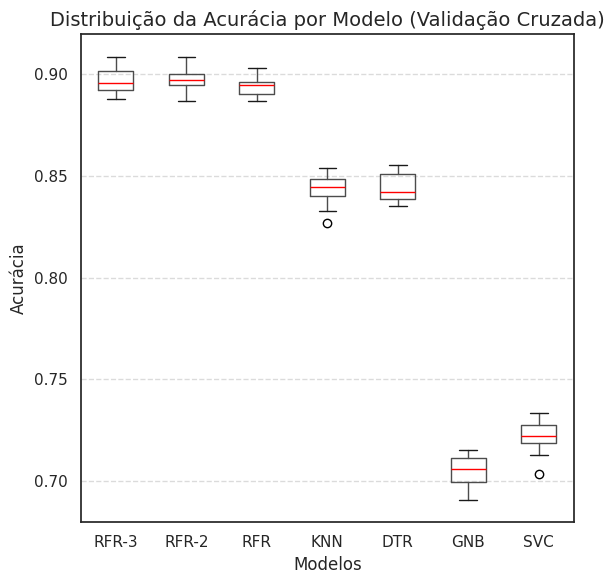

In [110]:
df_scores = pd.DataFrame(boxplot_data)

plt.figure(figsize=(6, 6))
df_scores.boxplot(grid=False, color={'medians': 'red'})

plt.title("Distribuição da Acurácia por Modelo (Validação Cruzada)", fontsize=14)
plt.xlabel("Modelos", fontsize=12)
plt.ylabel("Acurácia", fontsize=12)
# plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()  # Ajusta o layout para evitar cortes
plt.show()

## Construção do modelo principal


### Definição do modelo e preprocessamento


In [ ]:
preprocessor = ColumnTransformer(
    transformers=best_transformers
)

pipeline = Pipeline(
    steps=[
        ("preprocessor", preprocessor),
        ("model", models[0][1]), # Melhor modelo renomeado para model (necessário para passagem de parâmetros)
    ]
)

### Otimização dos hiperparâmetros do modelo


Abaixo foram deixadas apenas alguma opções para que a busca não demore. Embora o resultado seja um pouco variável foram escolhidos os parâmetros com melhor desempenho até agora.

In [ ]:
param_grid = {
    # Parâmetros do pré-processador (se aplicável)
    # 'preprocessor__num__with_mean': [True, False],  # Exemplo para StandardScaler
    # Parâmetros do modelo
    "model__criterion": [
        # "gini",
        "entropy",
        "log_loss", # Melhor resultado
    ],
    "model__n_estimators": [
        # 50,
        # 80,
        # 100,
        # 125,
        150,
        175,  # Melhor resultado
        # 200,
    ],
    "model__max_depth": [
        # None,
        # 10,
        15, # Melhor resultado
        20,
        # 30,
    ],
    "model__min_samples_split": [
        # 2,
        # 5,
        8,  # Melhor resultado
        10,
        # 14,
        # 20,
    ],
    "model__max_features": [
        "sqrt",
        # "log2",
    ],
}

from sklearn.model_selection import GridSearchCV

grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    cv=5,
    scoring="accuracy",
    n_jobs=-1,
    verbose=1,
)

grid_search.fit(features, target)
print(f"Melhor combinação de parâmetros: {grid_search.best_params_}")
print(f"Melhor pontuação: {grid_search.best_score_:.3f}")

grid_search_result = pd.DataFrame(grid_search.cv_results_)[
    ["params", "mean_test_score", "rank_test_score"]
].sort_values("rank_test_score")

grid_search_result

Fitting 5 folds for each of 144 candidates, totalling 720 fits


Melhor combinação de parâmetros: {'model__criterion': 'log_loss', 'model__max_depth': 15, 'model__max_features': 'sqrt', 'model__min_samples_split': 8, 'model__n_estimators': 100}
Melhor pontuação: 0.898


params  mean_test_score  \
72   {'model__criterion': 'log_loss', 'model__max_d...         0.898112   
87   {'model__criterion': 'log_loss', 'model__max_d...         0.897678   
101  {'model__criterion': 'log_loss', 'model__max_d...         0.897582   
27   {'model__criterion': 'entropy', 'model__max_de...         0.897341   
135  {'model__criterion': 'log_loss', 'model__max_d...         0.897341   
..                                                 ...              ...   
29   {'model__criterion': 'entropy', 'model__max_de...         0.894739   
33   {'model__criterion': 'entropy', 'model__max_de...         0.894643   
9    {'model__criterion': 'entropy', 'model__max_de...         0.894595   
32   {'model__criterion': 'entropy', 'model__max_de...         0.894354   
58   {'model__criterion': 'entropy', 'model__max_de...         0.894209   

     rank_test_score  
72                 1  
87                 2  
101                3  
27                 4  
135                5  
..               ...  
29               140  
33               141  
9                142  
32               143  
58               144  

[144 rows x 3 columns]

### Visualização detalhada do desempenho


#### Treino e teste (apenas para exemplificar)


Esta seção foi mantida apenas para mostrar o progresso de desenvolvimento, mas todo o relatório de classificação feito aqui, foi refeito (e aprimorado) com validação cruzada, que dá mais confiabilidade a todas as métricas por calculá-las sobre todo o conjunto de dados.


In [117]:
X_train, X_test, y_train, y_test = train_test_split(
    features, target, test_size=0.2, random_state=42
)

pipeline.fit(X_train, y_train)


y_pred = pipeline.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f"\nAcurácia do modelo: {accuracy:.3f}")

print("\nRelatório de Classificação:")
print(
    classification_report(
        y_test,
        y_pred,
        target_names=target_order,
    )
)


Acurácia do modelo: 0.894

Relatório de Classificação:
                     precision    recall  f1-score   support

Insufficient_Weight       0.94      0.93      0.93       524
      Normal_Weight       0.85      0.88      0.87       626
 Overweight_Level_I       0.77      0.74      0.76       484
Overweight_Level_II       0.77      0.78      0.78       514
     Obesity_Type_I       0.87      0.87      0.87       543
    Obesity_Type_II       0.97      0.97      0.97       657
   Obesity_Type_III       1.00      1.00      1.00       804

           accuracy                           0.89      4152
          macro avg       0.88      0.88      0.88      4152
       weighted avg       0.89      0.89      0.89      4152



#### Relatório de classificação detalhado


Vamos obter predições para todo o conjunto de treino através de validação cruzada.


In [118]:
y_pred_cv = cross_val_predict(
    pipeline,
    features,
    target,
    cv=5,
    method="predict",
)

A seguir vemos um relatório geral de classificação para o modelo escolhido, que apresenta métricas de desempenho gerais e para cada uma das classes do atributo que queremos estimar.


In [119]:
print(f"\nAcurácia do modelo: {accuracy_score(target, y_pred_cv):.3f}")
print("\nRelatório de Classificação:")
print(classification_report(target, y_pred_cv, target_names=target_order))


Acurácia do modelo: 0.896

Relatório de Classificação:
                     precision    recall  f1-score   support

Insufficient_Weight       0.93      0.93      0.93      2523
      Normal_Weight       0.85      0.89      0.87      3082
 Overweight_Level_I       0.79      0.73      0.76      2427
Overweight_Level_II       0.77      0.79      0.78      2522
     Obesity_Type_I       0.88      0.88      0.88      2910
    Obesity_Type_II       0.97      0.97      0.97      3248
   Obesity_Type_III       1.00      1.00      1.00      4046

           accuracy                           0.90     20758
          macro avg       0.88      0.88      0.88     20758
       weighted avg       0.90      0.90      0.90     20758



Para detalhar mais o comportamento que o modelo segue em cada uma das classes, a seguir apresentamos a matriz de confusão.


<Axes: >

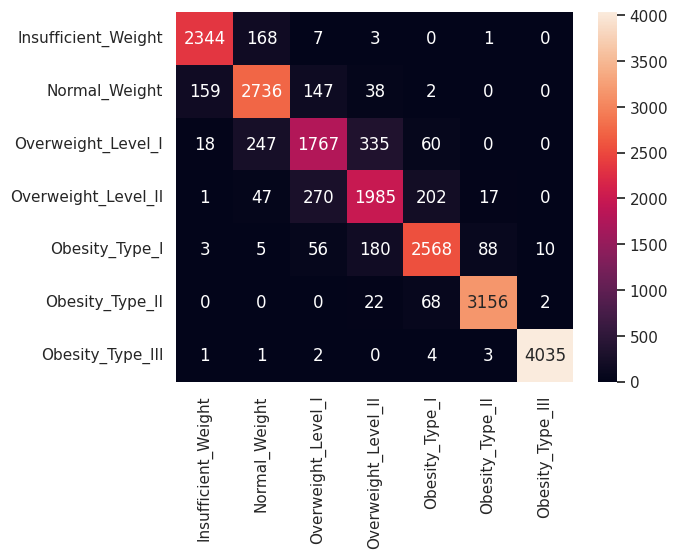

In [120]:
sns.heatmap(
    confusion_matrix(target, y_pred_cv),
    annot=True,
    fmt="d",
    xticklabels=target_order,
    yticklabels=target_order,
)

#### Comparação entre desempenho de treino e teste


In [121]:
scoring = {
    "accuracy": make_scorer(accuracy_score),
    "precision_macro": make_scorer(precision_score, average="macro"),
    "recall_macro": make_scorer(recall_score, average="macro"),
    "f1_macro": make_scorer(f1_score, average="macro"),
}

cv_results = cross_validate(
    pipeline,
    features,
    target,
    cv=5,
    # cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
    scoring=scoring,
    return_train_score=True,
)

In [122]:
# Cria um DataFrame com os resultados por fold
results_per_fold = pd.DataFrame(
    {
        # 'Fold': range(1, 6),
        "Acurácia (Treino)": cv_results["train_accuracy"],
        "Acurácia (Teste)": cv_results["test_accuracy"],
        "Precisão (Treino)": cv_results["train_precision_macro"],
        "Precisão (Teste)": cv_results["test_precision_macro"],
        "Recall (Treino)": cv_results["train_recall_macro"],
        "Recall (Teste)": cv_results["test_recall_macro"],
        "F1-Score (Treino)": cv_results["train_f1_macro"],
        "F1-Score (Teste)": cv_results["test_f1_macro"],
    }
)

# Adiciona médias ao final
results_per_fold.loc["Média"] = results_per_fold.mean()
results_per_fold.loc["Desvio Padrão"] = results_per_fold.std()

accuracy = results_per_fold.loc["Média"]["Acurácia (Teste)"]
Overfitting = (
    1
    - results_per_fold.loc["Média"]["Acurácia (Teste)"]
    / results_per_fold.loc["Média"]["Acurácia (Treino)"]
)

print(f"Acurácia (Teste): {accuracy:.4f}")
print(f"     Overfitting: {100*Overfitting:.2f}%")

print("\nMétricas por Fold, com Média e Desvio Padrão:")
display(results_per_fold.round(3))

Acurácia (Teste): 0.8951
     Overfitting: 7.59%

Métricas por Fold, com Média e Desvio Padrão:


Acurácia (Treino)  Acurácia (Teste)  Precisão (Treino)  \
0                          0.969             0.890              0.966   
1                          0.969             0.889              0.966   
2                          0.970             0.905              0.967   
3                          0.969             0.899              0.966   
4                          0.967             0.893              0.965   
Média                      0.969             0.895              0.966   
Desvio Padrão              0.001             0.006              0.001   

               Precisão (Teste)  Recall (Treino)  Recall (Teste)  \
0                         0.879            0.965           0.877   
1                         0.876            0.965           0.875   
2                         0.895            0.966           0.894   
3                         0.888            0.965           0.886   
4                         0.881            0.964           0.881   
Média                     0.884            0.965           0.883   
Desvio Padrão             0.007            0.001           0.007   

               F1-Score (Treino)  F1-Score (Teste)  
0                          0.965             0.878  
1                          0.965             0.876  
2                          0.967             0.895  
3                          0.966             0.887  
4                          0.964             0.881  
Média                      0.966             0.883  
Desvio Padrão              0.001             0.007

## Predição e Submissão


### Predição


In [123]:
pipeline.fit(features, target)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('Num1', 'passthrough',
                                                  ['Age', 'Height', 'Weight',
                                                   'FCVC', 'NCP', 'CH2O', 'FAF',
                                                   'TUE']),
                                                 ('G1',
                                                  OneHotEncoder(categories=[['Male',
                                                                             'Female']],
                                                                drop='first',
                                                                sparse_output=False),
                                                  ['Gender']),
                                                 ('CE2',
                                                  OrdinalEncoder(categories=[['no',
                                                                              'Sometimes',
                                                                              'Frequently',
                                                                              'Always']],
                                                                 dtype=<class 'int'>),
                                                  ['CAEC']),
                                                 ('C2',
                                                  OrdinalEncoder(categories=[['no',
                                                                              'Sometimes',
                                                                              'Frequently',
                                                                              'Always']],
                                                                 dtype=<class 'int'>),
                                                  ['CALC']),
                                                 ('M4',
                                                  OrdinalEncoder(categories=[['Walking',
                                                                              'Bike',
                                                                              'Motorbike',
                                                                              'Automobile',
                                                                              'Public_Transportation']],
                                                                 dtype=<class 'int'>),
                                                  ['MTRANS'])])),
                ('model',
                 RandomForestClassifier(max_depth=20, min_samples_split=8,
                                        n_estimators=175))])

In [124]:
prediction = pipeline.predict(test)
predicted_classes = target_encoder.inverse_transform(
    prediction.reshape(-1, 1)
).flatten()

predicted_df = pd.DataFrame({"id": test.id, "NObeyesdad": predicted_classes})

timestamp = datetime.now().strftime("%y%m%d%H%M")
file_name = f"{timestamp}_submit_{models[0][0]}_{'_'.join([t[0] for t in best_transformers])}.csv"

predicted_df.to_csv(f"../submission/{file_name}", index=False)

### Submissão


In [125]:
os.system(f'kaggle competitions submit -f ../submission/{file_name} -m "Submitted by Jupyter notebook" "playground-series-s4e2"')

100%|██████████| 311k/311k [00:01<00:00, 307kB/s]  


Successfully submitted to Multi-Class Prediction of Obesity Risk

0